# Coal production prediction in mines 2010

by: Geetha Aluri

Abstract: We did a lot of analysis and came to some interesting conclusions.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error

sns.set()

## Cleaned data

We cleaned this data in the notebook stored in: deliver/Data_cleaning.ipynb

In [2]:
df = pd.read_csv('../data/cleaned_coalpublic2010.csv', index_col='MSHA ID')
df.head()

,Year,Mine_Name,Mine_State,Mine_County,Mine_Basin,Mine_Status,Mine_Type,Company_Type,Operation_Type,Operating_Company,Operating_Company_Address,Union_Code,Production_(short_tons),Average_Employees,Labor_Hours,log_production
MSHA ID,,,,,,,,,,,,,,,,
103335,2010,Thompson South Mine,Alabama,Bibb,Appalachia Southern,Active,Surface,Independent Producer Operator,Mine only,"M&b Excavating Co., Inc., Llc","1001 Heflin Avenue West, Birmingham, AL 35214",NaN,103,1,30,4.634729
103381,2010,Tacoa Highwall Miner,Alabama,Bibb,Appalachia Southern,Active,Surface,Independent Producer Operator,Mine only,"Tacoa Minerals,llc","1669 Mission Hills Road, Alabaster, AL 35007",NaN,127564,13,33241,11.756373
103404,2010,Reid School Mine,Alabama,Blount,Appalachia Southern,Active,Surface,Independent Producer Operator,Mine only,"Taft Coal Sales & Associates,","107 N. Walston Bridge Road, Jasper, AL 35504",NaN,148994,32,76025,11.911661
103117,2010,"Mine #2, #3, #4",Alabama,Cullman,Appalachia Southern,Temporarily closed,Surface,Operating Subsidiary,Mine only,"Evergreen Mining, Llc","74 Indutrial Parkway, Jasper, AL 35001",NaN,69035,17,34365,11.142369
100759,2010,North River #1 Underground Min,Alabama,Fayette,Appalachia Southern,Active,Underground,Operating Subsidiary,Mine and Preparation Plant,Chevron Mining Inc,"3114 County Road 63 S, Berry, AL 35546",United Mine Workers of America,3037170,372,816059,14.926437


# Predict the production of coal mines

In [3]:
features = ['Average_Employees', 'Labor_Hours']

categoricals = [
    'Mine_State', 'Mine_County', 'Mine_Status', 'Mine_Type', 'Company_Type',
    'Operation_Type', 'Operating_Company', 'Union_Code'
]

target = 'log_production'

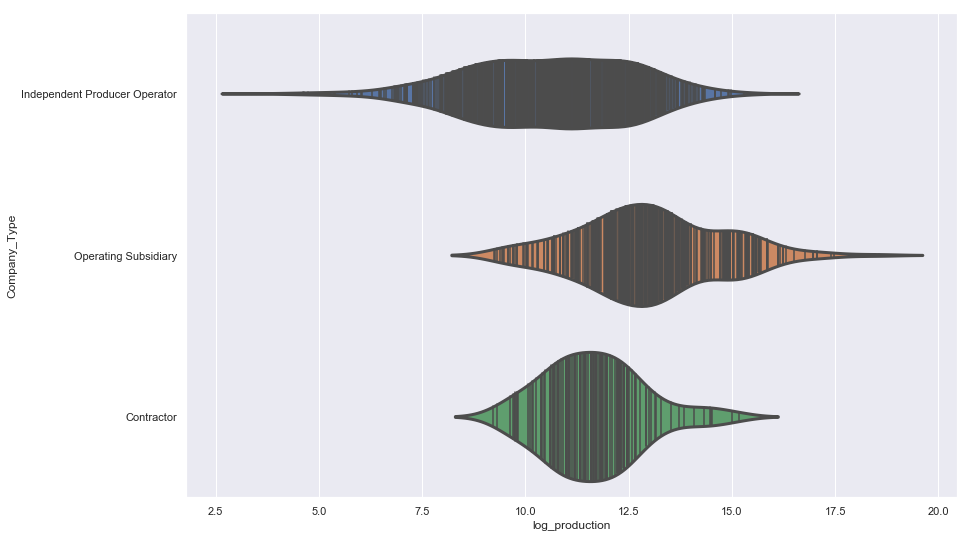

In [4]:
fig = plt.subplots(figsize=(14, 8))
sns.set_context('poster')

sns.violinplot(y='Company_Type',
               x='log_production',
               data=df,
               split=True,
               inner='stick')
plt.tight_layout()
plt.savefig('../figures/Coal_prediction_company_type_vs_production.png')

In [5]:
dummy_categoricals = []
for categorical in categoricals:
    print(categorical, len(df[categorical].unique()))
    drop_var = sorted(df[categorical].unique())[-1]
    temp_df = pd.get_dummies(df[categorical], prefix=categorical)
    df = pd.concat([df, temp_df], axis=1)
    temp_df.drop('_'.join([categorical, str(drop_var)]), axis=1, inplace=True)
    dummy_categoricals += temp_df.columns.tolist()

Mine_State 29
Mine_County 169
Mine_Status 4
Mine_Type 3
Company_Type 3
Operation_Type 3
Operating_Company 854
Union_Code 8


TypeError: '<' not supported between instances of 'str' and 'float'

# Random Forest Regressor

In [6]:
train, test = train_test_split(df, test_size=0.3)

In [7]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True)
rf.fit(train[features + dummy_categoricals], train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

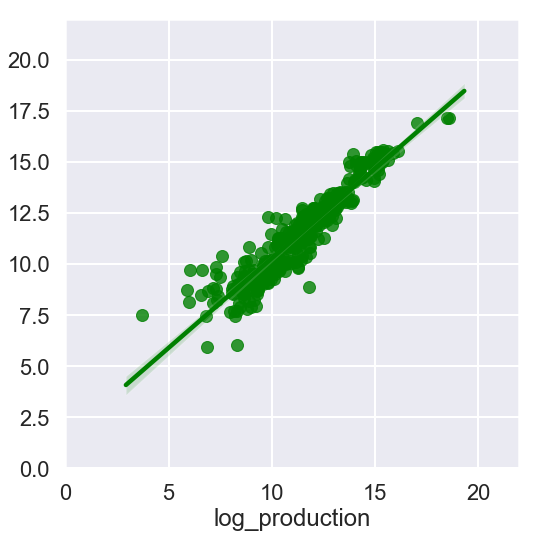

In [8]:
fig = plt.subplots(figsize=(8, 8))
sns.regplot(test[target], rf.predict(test[features + dummy_categoricals]), color='green')
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.tight_layout()
plt.savefig('../figures/Coal_production-RF-prediction.png')

In [9]:
predicted = rf.predict(test[features + dummy_categoricals])
r2_score(test[target], predicted)

0.8753593326768695

In [10]:
explained_variance_score(test[target], predicted)

0.8781131987129414

In [11]:
mean_squared_error(test[target], predicted)

0.5916018658436403

In [12]:
rf_importances = pd.DataFrame({
    'name': train[features + dummy_categoricals].columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

rf_importances.head(10)

,name,importance
0,Labor_Hours,0.794780
1,Average_Employees,0.087350
2,Mine_Type_Surface,0.008793
3,Mine_County_Campbell,0.005531
4,Mine_Type_Refuse,0.003196
5,Company_Type_Independent Producer Operator,0.003129
6,Operating_Company_Arch Of Wyoming Llc,0.002971
7,Operating_Company_Consol Of Kentucky Inc,0.002691
8,Operating_Company_Evans Coal Corp.,0.002568
9,Mine_State_Refuse Recovery,0.002491


# Conclusion

amazing conclusion